In [1]:
import wrf
import cartopy.crs as ccrs
import netCDF4 as nc
import glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import zipfile
import datetime as dt
import os
import tqdm
import pandas as pd
import warnings
from metpy.interpolate import cross_section
import xesmf


In [2]:
#Load the WRF simulation output. Currently, the standard wrfout files are hourly, whereas the highres files are 10-minute, but only contain surface winds
wrflist = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130_20200131_TWOWAY/wrfout*d03*"))]
wrflist_d02 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130_20200131_TWOWAY/wrfout*d02*"))]
wrflist_d03 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130_20200131_TWOWAY/wrfout*d01*"))]
wrflist_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130_20200131_TWOWAY/highres*d03*"))]
wrflist_d02_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130_20200131_TWOWAY/highres*d02*"))]
wrflist_d03_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20200130_20200131_TWOWAY/highres*d01*"))]

#Load the coarse domain wind speed, rainwater mixing ratio, and theta
SPEED3 = wrf.getvar(wrflist_d03,"wspd_wdir",timeidx=wrf.ALL_TIMES).isel({"wspd_wdir":0})
QR3 = wrf.getvar(wrflist_d03,"QRAIN",timeidx=wrf.ALL_TIMES)
theta3 = wrf.getvar(wrflist_d03,"theta",timeidx=wrf.ALL_TIMES)
T3 = wrf.getvar(wrflist_d03,"tk",timeidx=wrf.ALL_TIMES)
W3 = wrf.getvar(wrflist_d03,"W",timeidx=wrf.ALL_TIMES)

#Do the same for the high-res domain, and resample (temporally) to the coarse run (saved every three hours)
SPEED1 = wrf.getvar(wrflist,"wspd_wdir",timeidx=wrf.ALL_TIMES).isel({"wspd_wdir":0})
SPEED1 = SPEED1.sel({"Time":np.in1d(SPEED1.Time, SPEED3.Time)})
QR1 = wrf.getvar(wrflist,"QRAIN",timeidx=wrf.ALL_TIMES)
QR1 = QR1.sel({"Time":np.in1d(QR1.Time, QR3.Time)})
theta1 = wrf.getvar(wrflist,"theta",timeidx=wrf.ALL_TIMES)
theta1 = theta1.sel({"Time":np.in1d(theta1.Time, theta3.Time)})
T1 = wrf.getvar(wrflist,"tk",timeidx=wrf.ALL_TIMES)
T1 = T1.sel({"Time":np.in1d(T1.Time, T3.Time)})
W1 = wrf.getvar(wrflist,"W",timeidx=wrf.ALL_TIMES)
W1 = W1.sel({"Time":np.in1d(W1.Time, W3.Time)})
REFD1 = wrf.getvar(wrflist,"REFL_10CM",timeidx=wrf.ALL_TIMES)
REFD1 = REFD1.sel({"Time":np.in1d(REFD1.Time, SPEED3.Time)})

In [3]:
#Get the 10-min gust data
U10E = np.vstack([f["U10E"][:] for f in wrflist_hr])
V10E = np.vstack([f["V10E"][:] for f in wrflist_hr])
SPEED10 = np.sqrt(U10E**2+V10E**2)
TIMES = wrf.extract_times(wrflist_hr,wrf.ALL_TIMES)

## Thinking about the Nakamura (1996) convective gust parameterisation. Look at the vertically integrated, potential temperature deficit, integrated rainwater mixing ratio, and wind speed

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Text(0.5, 1.0, 'Theta time series (bottom level) for a downburst location (09:00 UTC)')

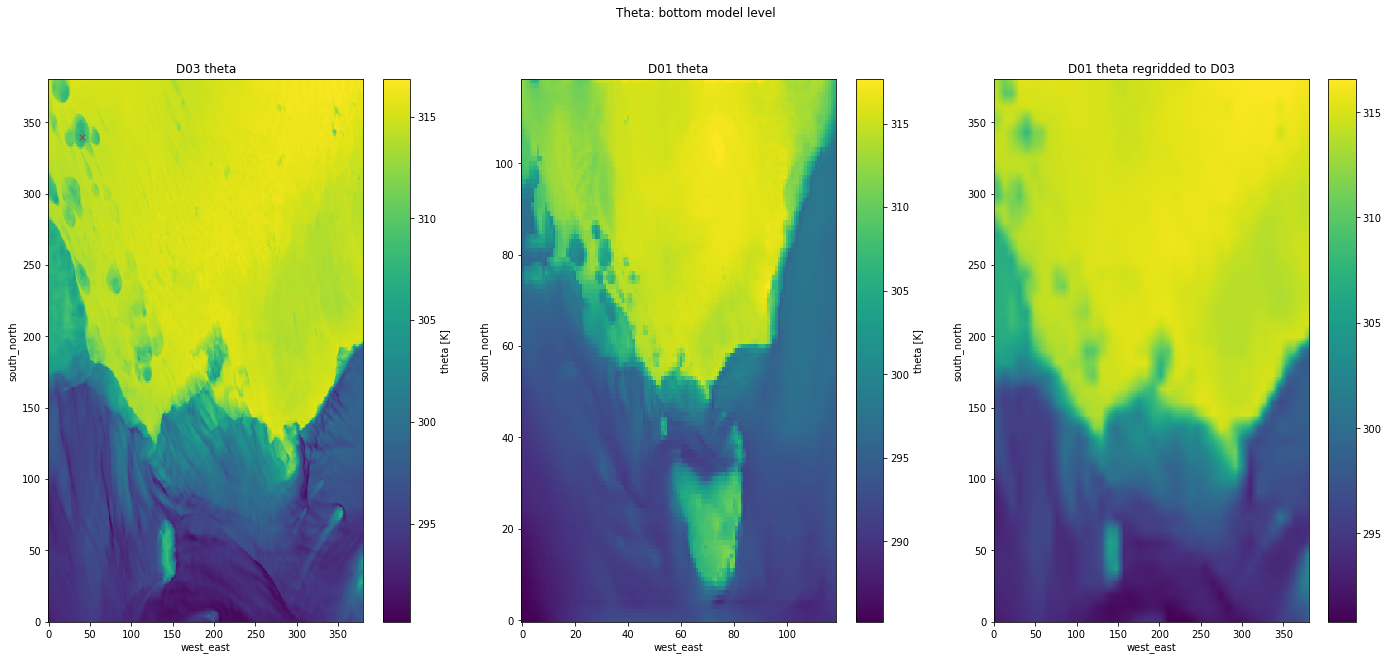

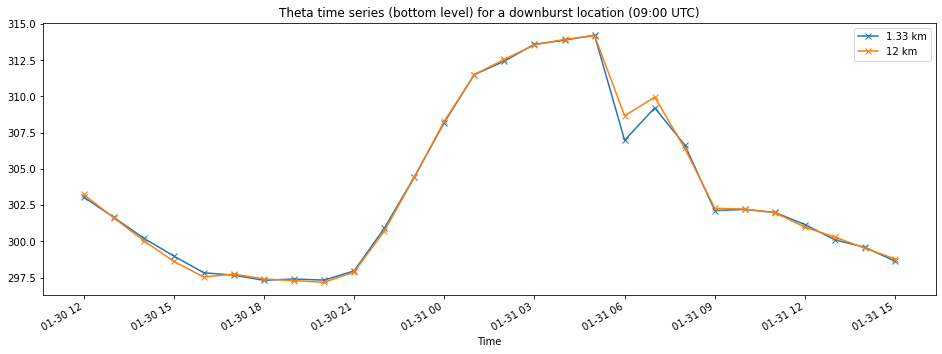

In [17]:
plt.figure(figsize=[24,10])

plt.subplot(1,3,1)

timeidx=18
i_idx=40
j_idx=340

theta1.isel({"Time":timeidx,"bottom_top":0}).plot()
plt.plot(i_idx,j_idx,marker="x",color="tab:red")
plt.title("D03 theta")

plt.subplot(1,3,2)
theta3.isel({"Time":timeidx,"bottom_top":0}).plot()
plt.title("D01 theta")

plt.subplot(1,3,3)
regridder = xesmf.Regridder(theta3.rename({"XLONG":"lon","XLAT":"lat"}),theta1.rename({"XLONG":"lon","XLAT":"lat"}),method="bilinear")
theta_regrid= regridder(theta3)
theta_regrid.isel({"Time":timeidx,"bottom_top":0}).plot()
plt.title("D01 theta regridded to D03")
plt.suptitle("Theta: bottom model level")

plt.figure(figsize=[16,5])
theta1.isel({"bottom_top":0,"south_north":j_idx,"west_east":i_idx}).plot(marker="x",label="1.33 km")
theta_regrid.isel({"bottom_top":0,"south_north":j_idx,"west_east":i_idx}).plot(marker="x",label="12 km")
plt.legend()
plt.title("Theta time series (bottom level) for a downburst location (09:00 UTC)")

Text(0.5, 1.0, 'Temperature (K)')

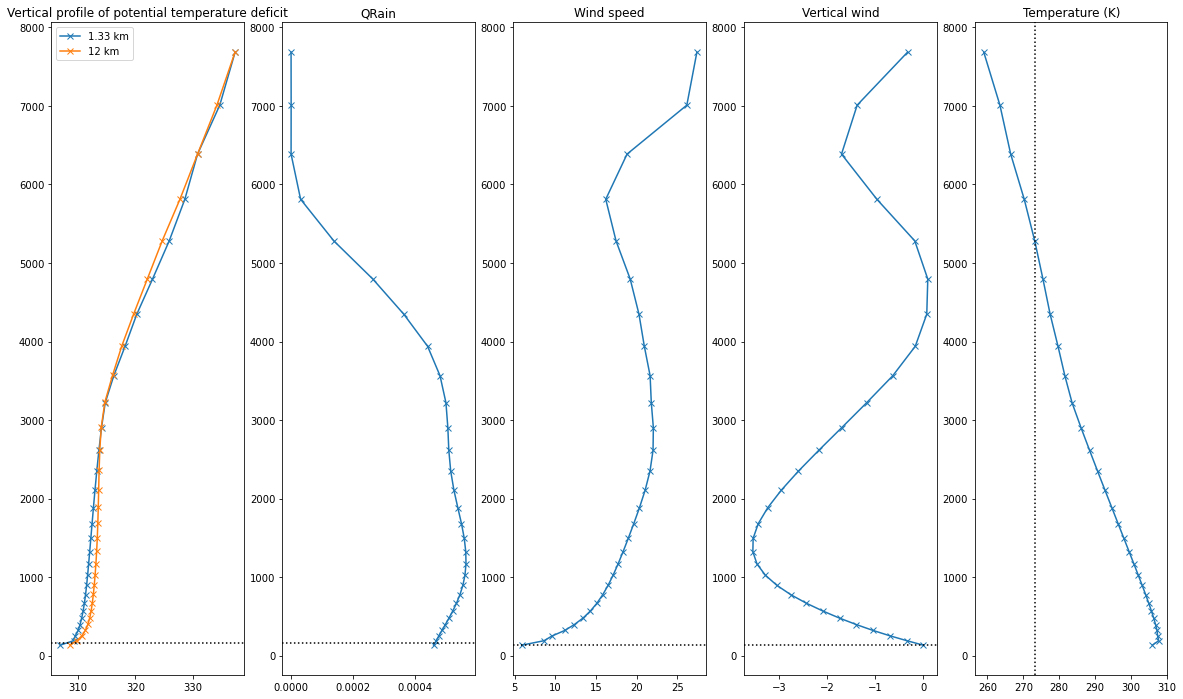

In [22]:
top=30
top_int=1

hgt_regrid = regridder(wrf.getvar(wrflist_d03,"z",timeidx=timeidx).isel({"bottom_top":slice(0,top)}))

plt.figure(figsize=[20,12])
plt.subplot(1,5,1)
x1=theta1.isel({"Time":timeidx,"south_north":j_idx,"west_east":i_idx,"bottom_top":slice(0,top)}).values; y1=wrf.getvar(wrflist,"z",timeidx=timeidx).isel({"south_north":j_idx,"west_east":i_idx,"bottom_top":slice(0,top)}).values; plt.plot(x1,y1,marker="x",label="1.33 km")
x2=theta_regrid.isel({"Time":timeidx,"south_north":j_idx,"west_east":i_idx,"bottom_top":slice(0,top)}).values; y2=hgt_regrid.isel({"south_north":j_idx,"west_east":i_idx}).values; plt.plot(x2,y2,marker="x",label="12 km")
plt.title("Vertical profile of potential temperature deficit")
plt.legend()
plt.gca().axhline((y2[top_int]+y2[top_int-1])/2,color="k",ls=":")

plt.subplot(1,5,2)
xqr = QR1.isel({"Time":timeidx,"south_north":j_idx,"west_east":i_idx,"bottom_top":slice(0,top)}).values
plt.plot(xqr,y1,marker="x",label="Rainwater mixing ratio")
plt.gca().axhline((y2[top_int]+y2[top_int-1])/2,color="k",ls=":")
plt.title("QRain")

plt.subplot(1,5,3)
speed = SPEED1.isel({"Time":timeidx,"south_north":j_idx,"west_east":i_idx,"bottom_top":slice(0,top)}).values
plt.plot(speed,y1,marker="x",label="Wind speed (m/s)")
plt.gca().axhline(y2[top_int-1],color="k",ls=":")
plt.title("Wind speed")

plt.subplot(1,5,4)
w = W1.isel({"Time":timeidx,"south_north":j_idx,"west_east":i_idx,"bottom_top_stag":slice(0,top)}).values
plt.plot(w,y1,marker="x",label="Wind speed (m/s)")
plt.gca().axhline(y2[top_int-1],color="k",ls=":")
plt.title("Vertical wind")

plt.subplot(1,5,5)
t = T1.isel({"Time":timeidx,"south_north":j_idx,"west_east":i_idx,"bottom_top":slice(0,top)}).values
plt.plot(t,y1,marker="x",label="Temperature (K)")
plt.gca().axvline(273.15,color="k",ls=":")
plt.title("Temperature (K)")

In [23]:
beta=1

ted = (x2-x1)[0:top_int]
qr = xqr[0:top_int]
v_h = speed[top_int]
nak_gust = np.sqrt( np.trapz(2*9.8* (ted/x2[0:top_int] + qr),y1[0:top_int]) + (beta*(v_h**2)))

print(nak_gust)

8.599067687988281


## Do the Nakamura calculation for the whole grid

In [26]:
#NOTES
# -> What if the downdraft hasn't reached the surface in the model? Then H will be zero. Maybe try H as the melting level, as well.
# -> If using the 12 km nest as an "environmental" profile, then do we need to use two-way nesting? Otherwise, differences between outer
#      and inner nest might be because the simulations diverge (i.e. the front is colder in the fine run)

beta=1

#Get the indices for each column when the parcel first becomes warmer than it's environment (or neutral)
#H = ((theta1-theta_regrid)>=0).argmax(dim="bottom_top")
H = ((theta1-theta_regrid)>=-1).argmax(dim="bottom_top")

#These indices define the downdraft start. Get wind speeds at this height
v_h = SPEED1.transpose("bottom_top","Time","south_north","west_east")[H-1]

#Get the difference between the environmental theta and the parcel theta. Positive means the parcel is colder.
ted = theta_regrid - theta1

#Extract heights for integration calculation. Mask the heights above the downdraft as 0
hgt=wrf.getvar(wrflist,"z").expand_dims(dim={"Time":ted.Time.shape[0]})
hgt["Time"] = ted.Time
#hgt=hgt.where((ted>=0) & (ted.bottom_top<=H),0)
hgt=hgt.where((ted.bottom_top<=H),0)

#Do the integration
nak_gust_3d = np.sqrt(\
                   np.trapz(\
                            2 * 9.8 * (ted / theta_regrid + QR1),\
                            x=hgt,axis=1)\
                   + (beta*v_h**2))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [27]:
#hgt.isel({"Time":timeidx,"south_north":j_idx,"west_east":i_idx}).argmax()
nak_gust_3d.isel({"Time":timeidx,"south_north":j_idx,"west_east":i_idx})

<xarray.DataArray 'wspd_wdir' ()>
array(5.1893144, dtype=float32)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XLONG      float32 142.4
    XLAT       float32 -36.23
    XTIME      float64 1.08e+03
    Time       datetime64[ns] 2020-01-31T06:00:00
    datetime   datetime64[ns] 2020-01-31T06:00:00
    lon        float32 142.4
    lat        float32 -36.23

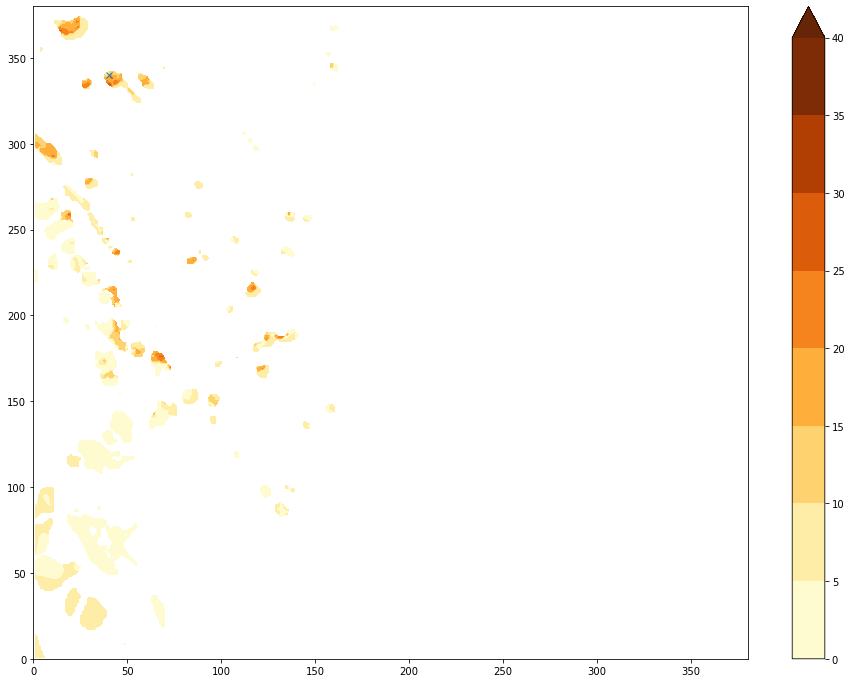

In [28]:
qr_mask = (QR1.transpose("bottom_top","Time","south_north","west_east")[H]>0.0003)
refd_mask = REFD1.max("bottom_top") > 30
w_mask = W1.isel({"bottom_top_stag":slice(0,10)}).min("bottom_top_stag") <= -0.1
sfc_ted_mask = ted.isel({"bottom_top":0})>0

plt.figure(figsize=[16,12])
plt.contourf(np.where(refd_mask,nak_gust_3d,np.nan)[timeidx],levels=np.arange(0,45,5),cmap=plt.get_cmap("YlOrBr"),extend="max")
plt.colorbar()

plt.plot(i_idx,j_idx,marker="x",color="tab:blue")

#xr.plot.contour(REFD1.isel({"Time":timeidx}).max("bottom_top"),levels=[30],colors="k")

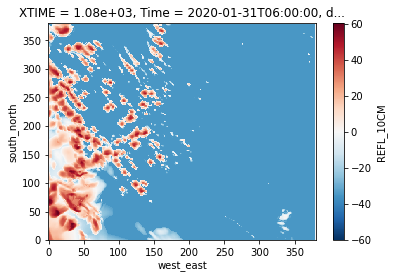

In [29]:
REFD1.isel({"Time":timeidx}).max("bottom_top").plot()

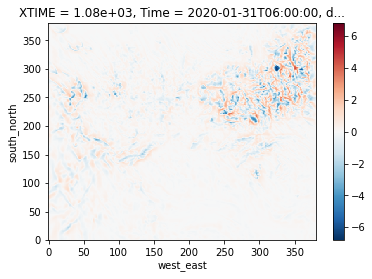

In [30]:
z=12
(T1.isel({"Time":timeidx,"bottom_top":z}) - regridder(T3.isel({"Time":timeidx,"bottom_top":z}))).plot()


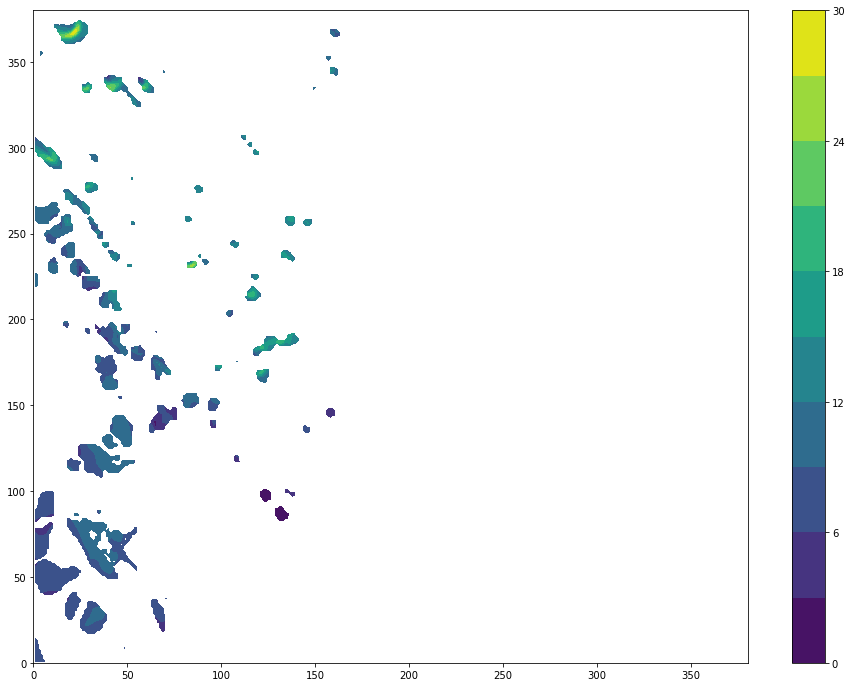

In [31]:
plt.figure(figsize=[16,12])
plt.contourf(np.where(refd_mask[timeidx],SPEED10[TIMES == SPEED1.Time.values[timeidx]].data.squeeze(),np.nan),levels=10)
plt.colorbar()

In [33]:
#Load AWS data for this event (loading the whole year is most convenient, but takes a while)
aws = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/obs/aws/vic_one_min_gust/2020.csv")
aws = aws.set_index(pd.DatetimeIndex(aws.dt_utc))

<AxesSubplot:title={'center':'wspd_wdir = wspd'}, xlabel='dt_utc'>

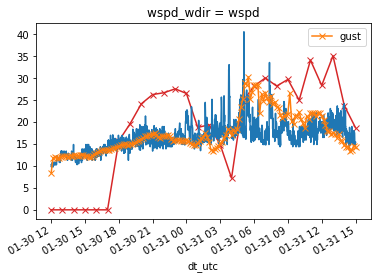

In [34]:
#Compare the state-wide maximum AWS gust time series with the domain-maximum WRF wind
ax=plt.axes()
y=(nak_gust_3d*refd_mask).max(("south_north","west_east")).plot(x="datetime",marker="x",color="tab:red",ax=ax)
aws.loc[slice("2020-01-30 12:00","2020-01-31 15:00")].groupby(level=0).max().gust.plot(ax=ax)
pd.DataFrame({"gust":np.max(SPEED10,axis=(1,2))}, index=TIMES).plot(color="tab:orange",ax=ax,marker="x")

